### Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса. \
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. \
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. \
У вас будет несколько задач :
- Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока— одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
- Вторая — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Подключим все необходимые библиотеки перед решением задач

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import phik
except ImportError:
    !pip install phik
    import phik

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (
    accuracy_score, mean_absolute_error, mean_squared_error,
    r2_score, confusion_matrix, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, make_scorer
)

from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

try:
    from yellowbrick.classifier import ROCAUC
except ImportError:
    !pip install yellowbrick
    from yellowbrick.classifier import ROCAUC

from sklearn.metrics import fbeta_score
from sklearn.dummy import DummyClassifier

try:
    from imblearn.over_sampling import RandomOverSampler, SMOTE
    from imblearn.combine import SMOTETomek
    from imblearn.under_sampling import RandomUnderSampler
except ImportError:
    !pip install imbalanced_learn
    from imblearn.over_sampling import RandomOverSampler, SMOTE
    from imblearn.combine import SMOTETomek
    from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

try:
    from optuna.integration import OptunaSearchCV
    from optuna import visualization
except ImportError:
    !pip install optuna
    from optuna.integration import OptunaSearchCV
    from optuna import visualization

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder,
    OrdinalEncoder, LabelEncoder, PolynomialFeatures
)

try:
    import shap
except ImportError:
    !pip install shap
    import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier

In [8]:
RANDOM_STATE = 55

# Задача 1: предсказание уровня удовлетворённости сотрудника

## Загрузка данных

In [9]:
try:
    train_data = pd.read_csv('train_job_satisfaction_rate.csv')
except:
    train_data = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
try:
    test_data_features = pd.read_csv('test_features.csv')
except:
    test_data_features = pd.read_csv('/datasets/test_features')
try:
    test_data_target = pd.read_csv('test_target_job_satisfaction_rate.csv')
except:
    test_data_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')


## Предобработка данных

Проверим данные на пропуски

In [10]:
train_data.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [11]:
test_data_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [12]:
test_data_target.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

в первых двух датасетах обнаружены пропуски, посмотрим, как выглядят эти строки

In [13]:
train_data[train_data['dept'].isna() | train_data['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [14]:
train_data[train_data['dept'].isna()].shape[0] / train_data.shape[0]

0.0015

In [15]:
train_data.shape[0]

4000

Заметим, что пропусков совсем немного, 6 строк по максимуму из 4000, думаю эти данные можно вовсе отбросить, но в будущем воспользуемся пайплайном, где стратегией заполнения будет `most-frequent`

In [16]:
test_data_features[test_data_features['dept'].isna() | test_data_features['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


Аналогично поступим и здесь

Проверим данные на явные дубликаты. Логичным будет искать дубликаты по столбцу `id`, так как вполне реально встретить двух одинаковых работников по данным остальных столбцов, а вот `id` уникально

In [17]:
train_data['id'].duplicated().sum()

0

In [18]:
test_data_features['id'].duplicated().sum()

0

In [19]:
test_data_target['id'].duplicated().sum()

0

Проверим данные на неявные дубликаты

In [20]:
for col in train_data.columns:
    if col != 'id' and train_data[col].dtype == 'object' :
        print("col = ", col)
        print(train_data[col].unique())
        print()
        print()

col =  dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]


col =  level
['junior' 'middle' 'sinior' nan]


col =  workload
['medium' 'high' 'low']


col =  last_year_promo
['no' 'yes']


col =  last_year_violations
['no' 'yes']




Неявных дубликтов не обнаружено

In [21]:
for col in test_data_features.columns:
    if col != 'id' and train_data[col].dtype == 'object' :
        print("col = ", col)
        print(train_data[col].unique())
        print()
        print()

col =  dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]


col =  level
['junior' 'middle' 'sinior' nan]


col =  workload
['medium' 'high' 'low']


col =  last_year_promo
['no' 'yes']


col =  last_year_violations
['no' 'yes']




## Вывод по предобработке данных:
Заметим, что пропусков совсем немного, 6 строк по максимуму из 4000, думаю эти данные можно вовсе отбросить, но в будущем воспользуемся пайплайном, где стратегией заполнения будет `most-frequent`

## Исследовательский анализ данных

In [22]:
num_cols = []
obj_cols = []
for col in train_data.columns:
    if col != 'id':
        if train_data[col].dtype == 'object' :
            obj_cols.append(col)
        else:
            num_cols.append(col)


In [23]:
num_cols

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

In [24]:
obj_cols

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

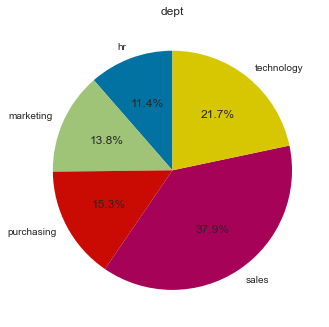

Соотношение максимальной группы к минимальной: 3.3157894736842106


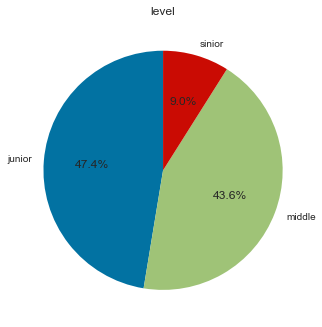

Соотношение максимальной группы к минимальной: 5.290502793296089


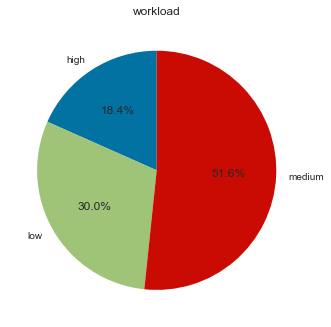

Соотношение максимальной группы к минимальной: 2.8147138964577656


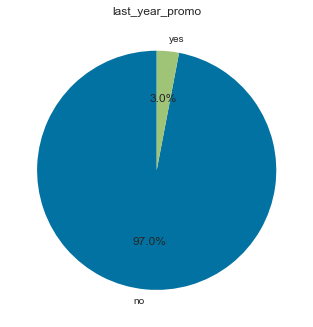

Соотношение максимальной группы к минимальной: 32.333333333333336


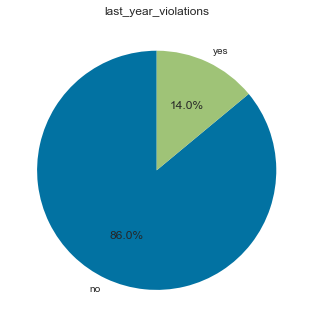

Соотношение максимальной группы к минимальной: 6.155635062611807


In [25]:
for col in obj_cols:
    data_tmp = train_data.pivot_table(index = col, values = 'id', aggfunc = 'count')
    plt.pie(data_tmp['id'], labels = data_tmp.index, autopct = '%1.1f%%', startangle = 90)
    plt.title(col)
    plt.show()
    print(f"Соотношение максимальной группы к минимальной: {data_tmp['id'].max() / data_tmp['id'].min()}")

По данным категориальных диаграмм можно сделать несколько выводов:
- Большая часть работников занимаются продажами, в то время как меньшая часть - hr, примерно поровну - маркетинг и закупки, почти второе место занимает отдел технологий
- Больше всего работников уровня джуниор и чуть меньше мидлов и совсем мало сеньоров, вполне ожидаемые показатели для почти любой компании
- По загруженности видно, что примерно половина занята средне, в то время как низкая загруженность у 30 процентов сотрудников, у 18 процентов - высокая
- Видно что повышение получили всего 3 процента сотрудников в течение года
- По диаграмме нарушений видно, что всего 14 процентов сотрудников нарушили трудовой договор, в целом хорошая цифра, но было бы хорошо иметь этот показатель еще более низким

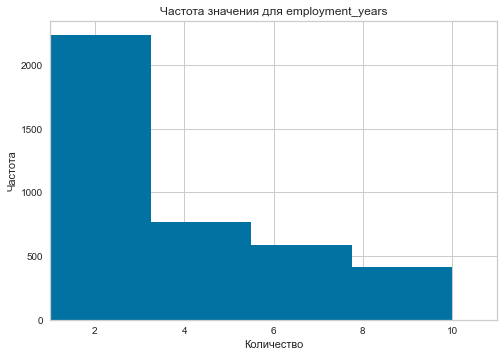

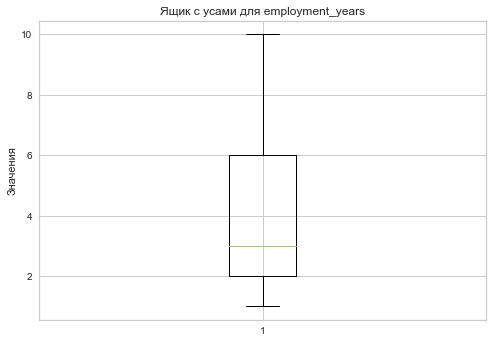



Статистика


count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

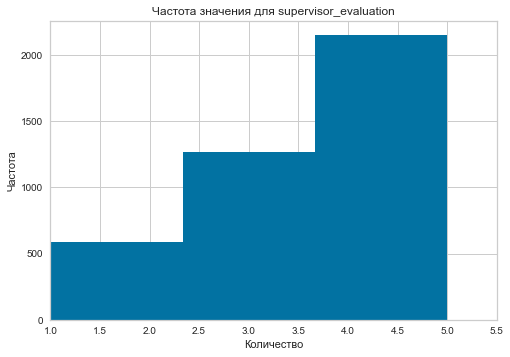

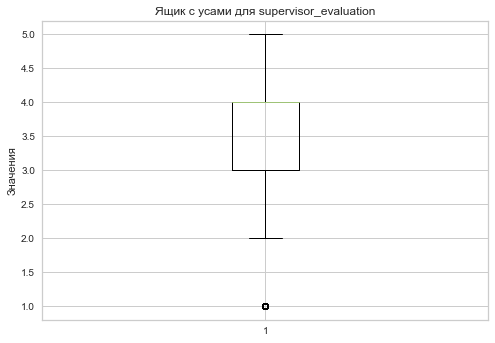



Статистика


count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

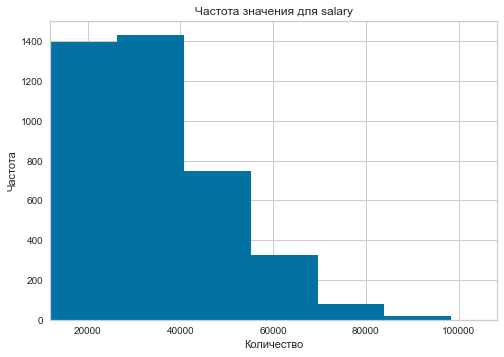

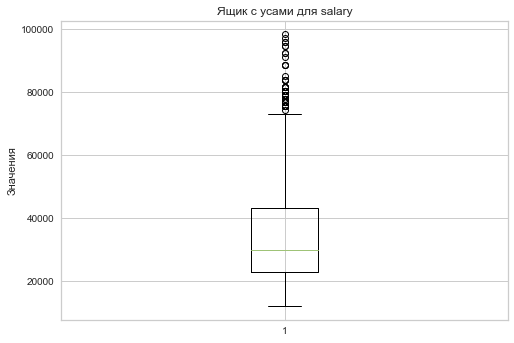



Статистика


count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

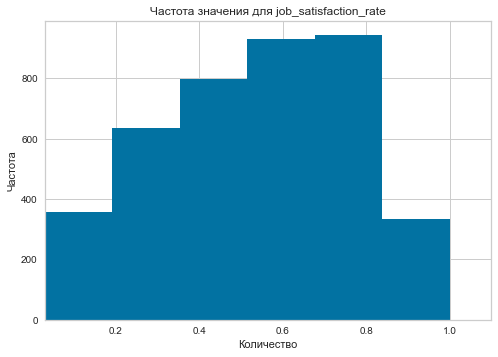

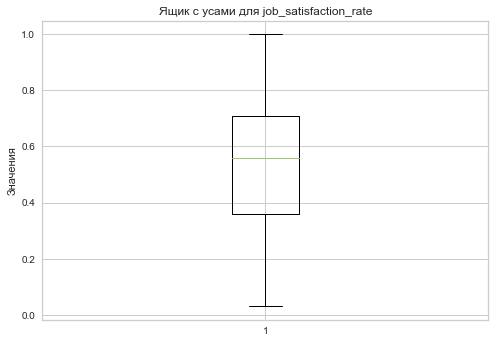



Статистика


count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

In [26]:
import math
for col in num_cols:
    print("\n")
    train_data[col].hist(bins = math.ceil(np.log(len(train_data[col].unique())) + 1))
    plt.xlim(train_data[col].min(), train_data[col].max() * 1.1)
    plt.title(f"Частота значения для {col}")
    plt.ylabel('Частота')
    plt.xlabel('Количество')
    plt.show()
    print("\n")
    plt.boxplot(train_data[col])
    plt.title(f"Ящик с усами для {col}")
    plt.ylabel('Значения')
    plt.show()
    print("\n")
    print("Статистика")
    display(train_data[col].describe())
    print("\n")
    print("\n")

Гистограмма стажа работы вполне примитивна, много сотрудников работают около двух лет, более опытных сотрудников меньше и меньше с увеличением значения стажа. \
Минимальный стаж сотрудников - 1 год, медиана - 3 года, максимальный - 10 лет


Гистограмма выставления оценок руководителем в принципе тоже ожидаема, множество сотрудников стараются, потому медиана составляет 4 из 5, но и присутсвуют недобросовестные сотрудники с оценкой равной 1.
Причем это явно выброс, стоит рассмотреть это значение отдельно

In [27]:
train_data[train_data['supervisor_evaluation'] == 1]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
18,848242,sales,middle,high,2,yes,no,1,50400,0.39
32,176144,hr,sinior,high,3,no,no,1,72000,0.22
45,538347,technology,sinior,high,3,no,no,1,84000,0.21
53,460328,technology,junior,high,1,no,no,1,37200,0.10
...,...,...,...,...,...,...,...,...,...,...
3877,947224,technology,junior,medium,3,no,no,1,30000,0.38
3949,157562,technology,middle,medium,3,no,no,1,49200,0.39
3972,134106,hr,middle,high,10,no,yes,1,57600,0.39
3988,806663,sales,middle,low,8,no,no,1,22800,0.39


Содержится 201 строчка с такой оценкой, причем уровни должности из всего спектра, сеньоры так же получают низкие оценки. Данные не являются аномалдьными, например есть hr со стажем в 10 лет, может он уже просто не компетентный, потому и получил такую оценку

График распределения зарплаты напоминает распределение Пуасонна, вполне ожидаемо, что хвост будет протягиваться в сторону высоких зарплат с медианой около начала координат. \
Минимальная зарплата - 12000, медиана - 30000, максимальная - 98400. Причем по ящику с усами видно, что наблюдаются выбросы выше 3 квантиля, что полне логично с таким распределением, людей многозарабатывающих не так много

Гистограмма оценки удовлетворенности сотрудника напоминает нормальное распределение, но с небольшим смещеним в бОльшую сторону, что весьма хорошо, это означает, что медиана находится выше чем половина оценки. Видно, что медиана составляет 0.56, в то время как наблюдаются очень подозрительные значения, 0.03 - минимальное, рассмотрим внимательно эти строчки

In [28]:
train_data[train_data['job_satisfaction_rate'] < 0.05]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
242,960700,sales,middle,medium,4,no,yes,2,37200,0.04
334,904973,technology,junior,medium,1,no,yes,2,25200,0.04
923,152252,sales,sinior,medium,5,no,yes,2,50400,0.04
2077,524656,technology,middle,high,1,no,yes,2,56400,0.04
2717,681745,technology,sinior,high,5,no,yes,3,76800,0.03
2788,653687,sales,middle,medium,4,no,yes,3,31200,0.03
3517,675936,hr,junior,medium,1,no,yes,3,22800,0.03


Видно, что все эти пользователи нарушили трудовой договор, потому ожидаемо, чем вызвана такая неудовлетворенность

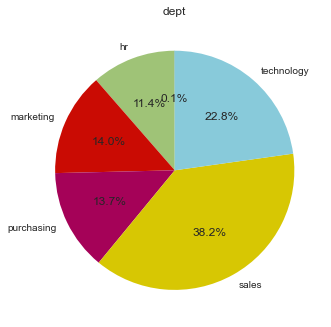

Соотношение максимальной группы к минимальной: 763.0


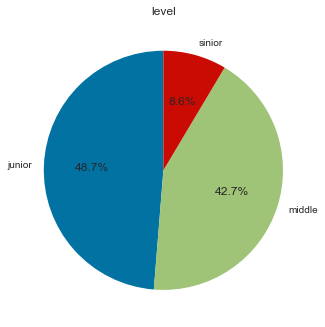

Соотношение максимальной группы к минимальной: 5.695906432748538


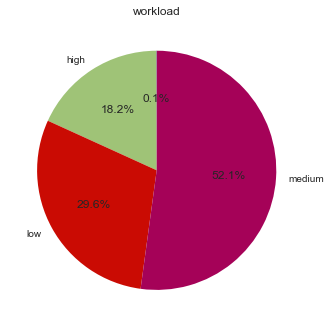

Соотношение максимальной группы к минимальной: 1043.0


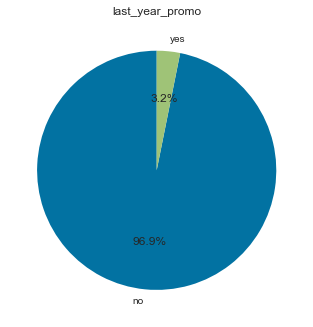

Соотношение максимальной группы к минимальной: 30.746031746031747


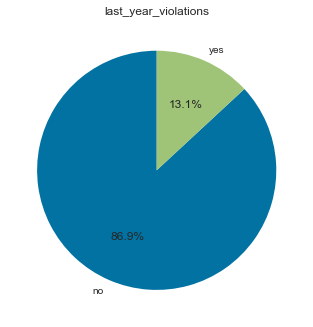

Соотношение максимальной группы к минимальной: 6.633587786259542


In [29]:
for col in obj_cols:
    data_tmp = test_data_features.pivot_table(index = col, values = 'id', aggfunc = 'count')
    plt.pie(data_tmp['id'], labels = data_tmp.index, autopct = '%1.1f%%', startangle = 90)
    plt.title(col)
    plt.show()
    print(f"Соотношение максимальной группы к минимальной: {data_tmp['id'].max() / data_tmp['id'].min()}")

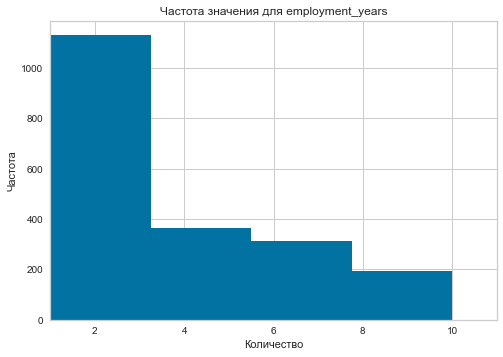

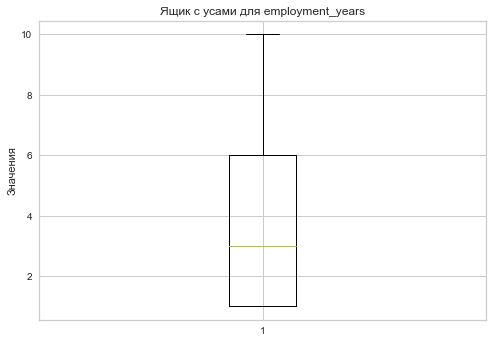



Статистика


count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

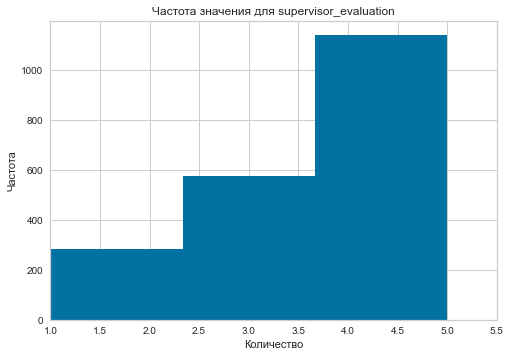

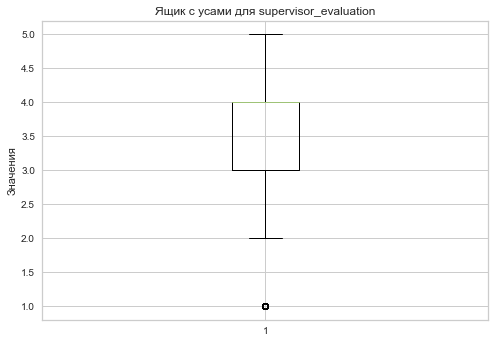



Статистика


count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

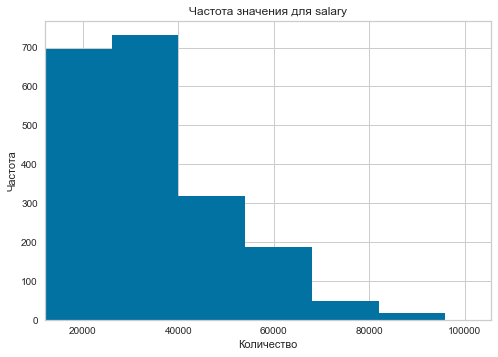

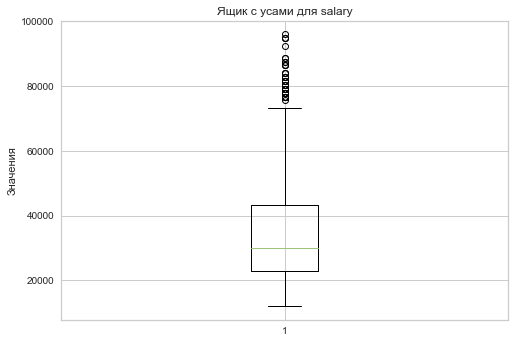



Статистика


count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

In [30]:
for col in num_cols:
    if col == 'job_satisfaction_rate':
        continue
    print("\n")
    test_data_features[col].hist(bins = math.ceil(np.log(len(test_data_features[col].unique())) + 1))
    plt.xlim(test_data_features[col].min(), test_data_features[col].max() * 1.1)
    plt.title(f"Частота значения для {col}")
    plt.ylabel('Частота')
    plt.xlabel('Количество')
    plt.show()
    print("\n")
    plt.boxplot(test_data_features[col])
    plt.title(f"Ящик с усами для {col}")
    plt.ylabel('Значения')
    plt.show()
    print("\n")
    print("Статистика")
    display(test_data_features[col].describe())
    print("\n")
    print("\n")

В тестовых данных ситуация аналогична

### Вывод по исследовательскому анализу:
По данным категориальных диаграмм можно сделать несколько выводов:
- Большая часть работников занимаются продажами, в то время как меньшая часть - hr, примерно поровну - маркетинг и закупки, почти второе место занимает отдел технологий
- Больше всего работников уровня джуниор и чуть меньше мидлов и совсем мало сеньоров, вполне ожидаемые показатели для почти любой компании
- По загруженности видно, что примерно половина занята средне, в то время как низкая загруженность у 30 процентов сотрудников, у 18 процентов - высокая
- Видно что повышение получили всего 3 процента сотрудников в течение года
- По диаграмме нарушений видно, что всего 14 процентов сотрудников нарушили трудовой договор, в целом хорошая цифра, но было бы хорошо иметь этот показатель еще более низким

Гистограмма стажа работы вполне примитивна, много сотрудников работают около двух лет, более опытных сотрудников меньше и меньше с увеличением значения стажа. \
Минимальный стаж сотрудников - 1 год, медиана - 3 года, максимальный - 10 лет
Гистограмма выставления оценок руководителем в принципе тоже ожидаема, множество сотрудников стараются, потому медиана составляет 4 из 5, но и присутсвуют недобросовестные сотрудники с оценкой равной 1.
Причем это явно выброс, Содержится 201 строчка с такой оценкой, причем уровни должности из всего спектра, сеньоры так же получают низкие оценки. Данные не являются аномалдьными, например есть hr со стажем в 10 лет, может он уже просто не компетентный, потому и получил такую оценку.

График распределения зарплаты напоминает распределение Пуасонна, вполне ожидаемо, что хвост будет протягиваться в сторону высоких зарплат с медианой около начала координат. \
Минимальная зарплата - 12000, медиана - 30000, максимальная - 98400. Причем по ящику с усами видно, что наблюдаются выбросы выше 3 квантиля, что полне логично с таким распределением, людей многозарабатывающих не так много

Гистограмма оценки удовлетворенности сотрудника напоминает нормальное распределение, но с небольшим смещеним в бОльшую сторону, что весьма хорошо, это означает, что медиана находится выше чем половина оценки. Видно, что медиана составляет 0.56, в то время как наблюдаются очень подозрительные значения, 0.03 - минимальное, видно, что все эти пользователи нарушили трудовой договор, потому ожидаемо, чем вызвана такая неудовлетворенность


## Корреляционный анализ

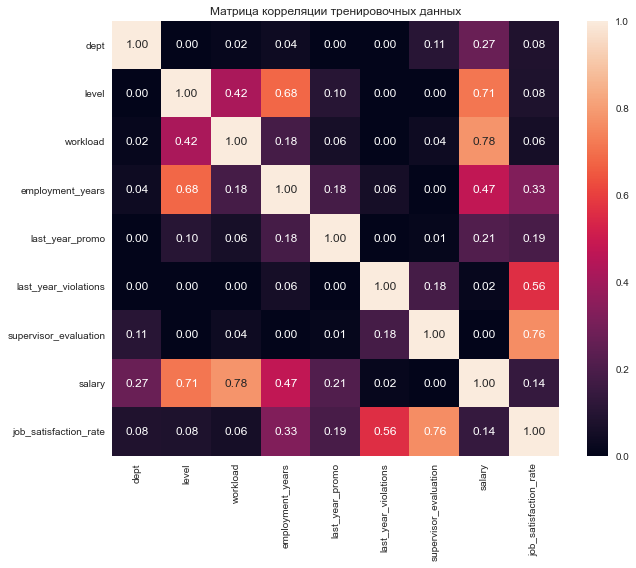

In [31]:
test_data = test_data_features.merge(test_data_target)
test_data.head()

interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

fig, axes = plt.subplots(figsize=(10, 8))
sns.heatmap(train_data.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f', ax=axes)

plt.title('Матрица корреляции тренировочных данных')
plt.show()


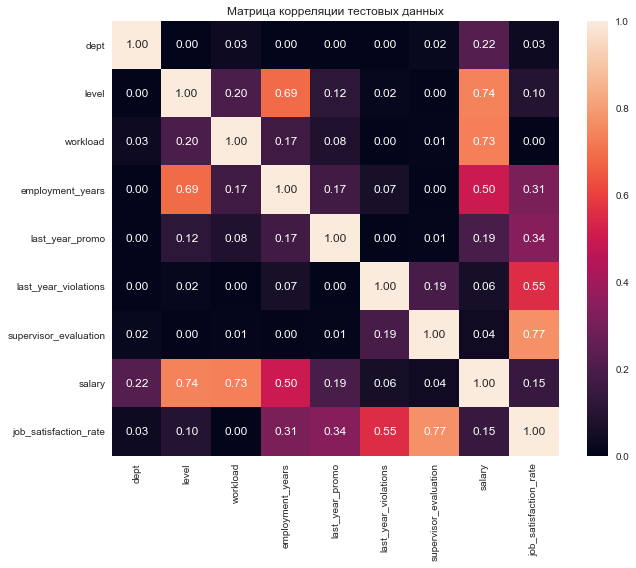

In [32]:
fig, axes = plt.subplots(figsize=(10, 8))
sns.heatmap(test_data.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f', ax=axes)

plt.title('Матрица корреляции тестовых данных')
plt.show()


По матрице корреляции видно, что наибольшие коэффициенты корреляции с таргет признаком имеют `supervisor_evaluation`, `last_year_violations`. Это вполне логично, так как наличие нарушений и оценка качества руководителя вполне могут так сильно влиять на таргет

## Подготовка данных

Так как в наших данных содержаться пропуски, то необходимо написать пайплайн, устраняющий их. Впоследствии мы напишем общий пайплайн, где данные пайплайны будут использоваться внутри

Рассмотрим значения в категориальных переменных

In [33]:
for col in obj_cols:
    print(col)
    print(train_data[col].unique())
    print()
    print()

dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]


level
['junior' 'middle' 'sinior' nan]


workload
['medium' 'high' 'low']


last_year_promo
['no' 'yes']


last_year_violations
['no' 'yes']




`level` закодируем при помощи OrdinalEncoder, остальные столбцы необходимо закодировать при помощи OneHotEncoder

In [34]:
ohe_cols = ['dept', 'workload', 'last_year_promo', 'last_year_violations']
ord_cols = ['level']
num_cols = ['employment_years', 'supervisor_evaluation', 'salary']
ohe_pipe = Pipeline([
        (
            'simple_imputer_ohe', 
            SimpleImputer(
                missing_values = np.nan, 
                strategy = 'most_frequent'
            )
        ),
        (
            'ohe', 
            OneHotEncoder(
                drop = 'first', 
                handle_unknown = 'ignore'
            )
        )
    ]
)

ord_pipe = Pipeline([
        (
            'simple_imputer_ord_before', 
            SimpleImputer(
                missing_values = np.nan, 
                strategy = 'most_frequent'
            )
        ),
        (
            'ord',
            OrdinalEncoder(
                categories = [
                    ['junior', 'middle', 'sinior']
                ],
                handle_unknown = 'use_encoded_value',
                unknown_value = np.nan
            )
        ),
        (
            'simple_imputer_ord_after', 
            SimpleImputer(
                missing_values = np.nan, 
                strategy = 'most_frequent'
            )
        )
    ]
)

Стратегией заполнения я выбрал `most_frequent`, так как пропусков совсем немного, не будет критичным заполнить пропуски именно так

In [35]:
data_preprocessing = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder = 'passthrough'
)

## Обучение моделей

Напишем итоговый пайплайн, который будет перебирать SVM, lin reg, DCR и их гиперпараметры, затем вернем оттуда лучшую модель

In [36]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessing),
        ('models', LinearRegression())
    ]
)

In [37]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__min_samples_split': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVR()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],  
        'models__kernel' : ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [Lasso(random_state = RANDOM_STATE), Ridge(random_state = RANDOM_STATE)],  
        'models__alpha': [0, 0.2, 0.25, 0.3, 0.5, 0.75, 0.8, 0.9, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


In [38]:
y_train = train_data['job_satisfaction_rate']
X_train = train_data.drop(['id', 'job_satisfaction_rate'], axis=1)

In [39]:
def smape_func(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denumerator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(numerator / denumerator) * 100

smape = make_scorer(smape_func, greater_is_better = False)

In [40]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    scoring = smape,
    random_state = RANDOM_STATE,
    n_jobs = -1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[

In [41]:
best_model = randomized_search.best_estimator_['models']
best_model_preprocessor = randomized_search.best_estimator_['preprocessor']

In [42]:
test_data_encoded = best_model_preprocessor.transform(test_data.drop(['id', 'job_satisfaction_rate'], axis = 1))
y_predict = best_model.predict(test_data_encoded)

Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros


In [43]:
smape_func(test_data['job_satisfaction_rate'], y_predict)

13.820517882221425

## Оформление выводов

В ходе выполнения первого задания удалось обучить модель `SVR`, показавшую примерно результат ~13.8 по метрике smape, что удовлетворяет нашим требованиям

# Задача 2: предсказание увольнения сотрудника из компании

## Загрузка данных

In [44]:
try:
    train_data_quit = pd.read_csv('train_quit.csv')
except:
    train_data_quit = pd.read_csv('/datasets/train_quit.csv')
try:
    test_data_target_quit = pd.read_csv('test_target_quit.csv')
except:
    test_data_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

## Предобработка данных

In [45]:
test_data_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [46]:
train_data_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Рассмотрим на наличие пропусков данные

In [47]:
train_data_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [48]:
test_data_target_quit.isna().sum()

id      0
quit    0
dtype: int64

Пропуски не обнаружены, проверим данные на явные дубликаты

In [49]:
train_data_quit['id'].duplicated().sum()

0

In [50]:
test_data_target_quit['id'].duplicated().sum()

0

Проверим данные на неявные дубликаты

In [51]:
for col in train_data_quit.columns:
    if col == 'id':
        continue
    print(col)
    print(train_data_quit[col].unique())
    print()
    print()

dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']


level
['middle' 'junior' 'sinior']


workload
['high' 'medium' 'low']


employment_years
[ 2  5  1  8  4  7  3  9  6 10]


last_year_promo
['no' 'yes']


last_year_violations
['no' 'yes']


supervisor_evaluation
[4 1 3 5 2]


salary
[54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800
 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000
 21600 38400 62400 40800 56400 34800 28800 52800 20400 36000 61200 48000
 43200 73200 31200 78000 64800 72000 94800 96000 63600 79200 55200 42000
 49200 50400 14400 13200 51600 67200 88800 68400 69600 70800 84000 81600
 87600 75600 91200 76800 74400 80400 85200 86400 92400]


quit
['no' 'yes']




Неявные дубликаты не обнаружены

### Вывод по предобработке данных:
Пропуски, дубликаты в данных не обнаружены, оставим все как есть

## Исследовательский анализ данных

In [52]:
num_cols = []
obj_cols = []
for col in train_data_quit.columns:
    if col != 'id':
        if train_data_quit[col].dtype == 'object' :
            obj_cols.append(col)
        else:
            num_cols.append(col)


In [53]:
obj_cols

['dept',
 'level',
 'workload',
 'last_year_promo',
 'last_year_violations',
 'quit']

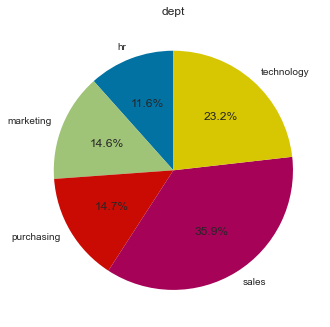

Соотношение максимальной группы к минимальной: 3.0991379310344827


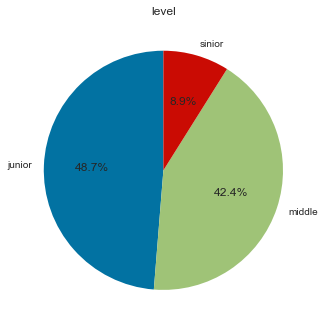

Соотношение максимальной группы к минимальной: 5.459383753501401


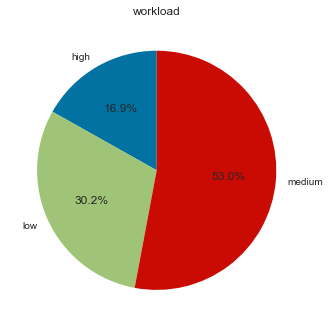

Соотношение максимальной группы к минимальной: 3.142433234421365


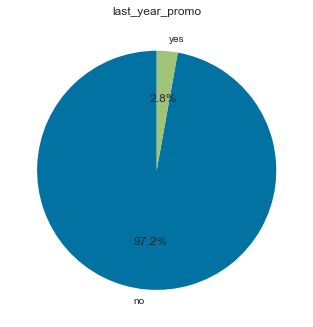

Соотношение максимальной группы к минимальной: 34.39823008849557


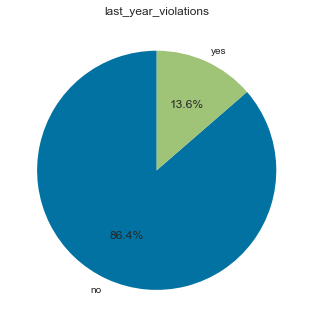

Соотношение максимальной группы к минимальной: 6.339449541284404


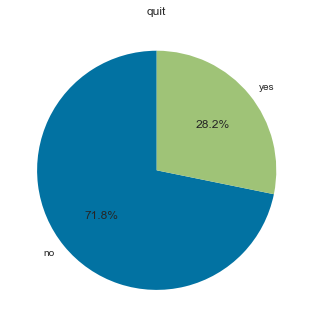

Соотношение максимальной группы к минимальной: 2.5460992907801416


In [54]:
for col in obj_cols:
    data_tmp = train_data_quit.pivot_table(index = col, values = 'id', aggfunc = 'count')
    plt.pie(data_tmp['id'], labels = data_tmp.index, autopct = '%1.1f%%', startangle = 90)
    plt.title(col)
    plt.show()
    print(f"Соотношение максимальной группы к минимальной: {data_tmp['id'].max() / data_tmp['id'].min()}")

Смотря на диаграммы категориальных признаков, можно сказать, что выводы совпадают с выводами в ходе исследовательского анализа первой задачи, но нужно добавить про колонку `quit`, а именно, что процент уволенных сотрудников ~28%, что довольно много, как я считаю

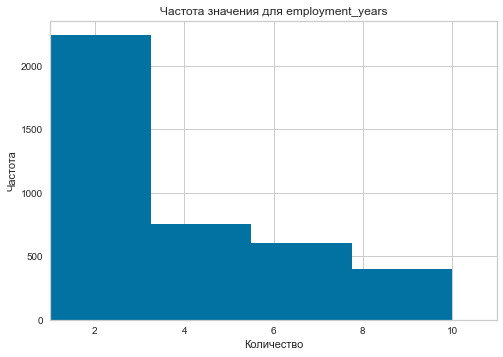

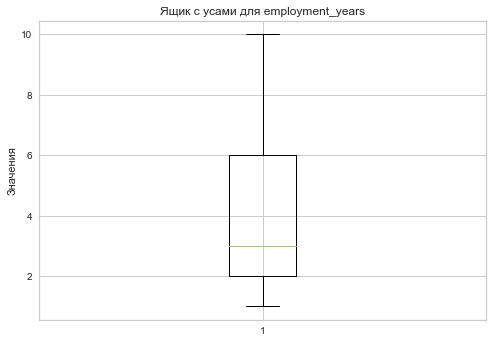



Статистика


count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

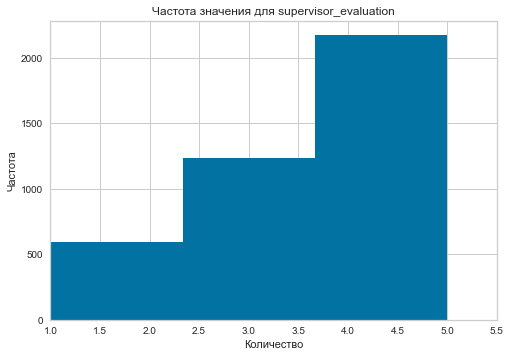

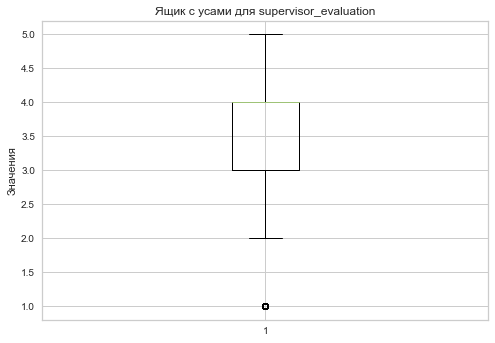



Статистика


count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

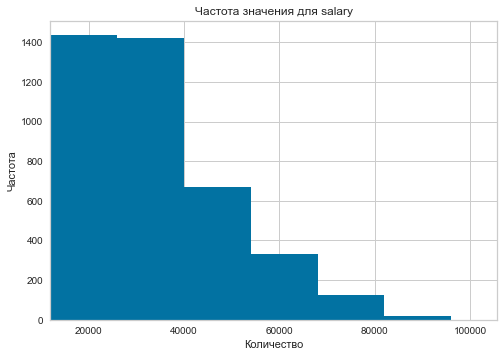

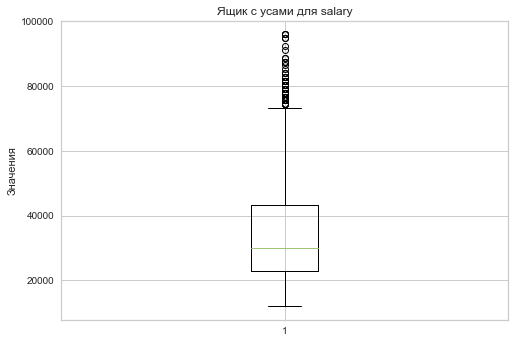



Статистика


count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

In [55]:
for col in num_cols:
    if col == 'quit':
        continue
    print("\n")
    train_data_quit[col].hist(bins = math.ceil(np.log(len(train_data_quit[col].unique())) + 1))
    plt.xlim(train_data_quit[col].min(), train_data_quit[col].max() * 1.1)
    plt.title(f"Частота значения для {col}")
    plt.ylabel('Частота')
    plt.xlabel('Количество')
    plt.show()
    print("\n")
    plt.boxplot(train_data_quit[col])
    plt.title(f"Ящик с усами для {col}")
    plt.ylabel('Значения')
    plt.show()
    print("\n")
    print("Статистика")
    display(train_data_quit[col].describe())
    print("\n")
    print("\n")

Гистограмма стажа работы вполне примитивна, много сотрудников работают около двух лет, более опытных сотрудников меньше и меньше с увеличением значения стажа. \
Минимальный стаж сотрудников - 1 год, медиана - 3 года, максимальный - 10 лет
Гистограмма выставления оценок руководителем в принципе тоже ожидаема, множество сотрудников стараются, потому медиана составляет 4 из 5, но и присутсвуют недобросовестные сотрудники с оценкой равной 1.

График распределения зарплаты напоминает распределение Пуасонна, вполне ожидаемо, что хвост будет протягиваться в сторону высоких зарплат с медианой около начала координат. \
Минимальная зарплата - 12000, медиана - 30000, максимальная - 96000. Причем по ящику с усами видно, что наблюдаются выбросы выше 3 квантиля, что полне логично с таким распределением, людей многозарабатывающих не так много


## Портрет «уволившегося сотрудника»

Отберем ушедших сотрудников и построим необходимые диаграммы

In [56]:
quit_data = train_data_quit.query('quit == "yes"')
quit_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


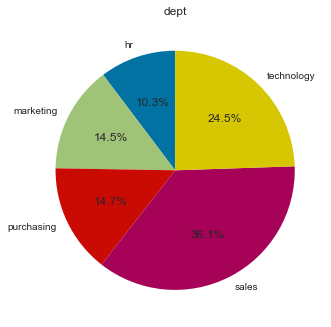

Соотношение максимальной группы к минимальной: 3.5086206896551726


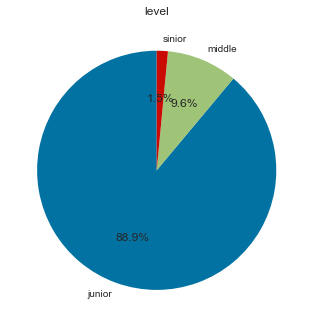

Соотношение максимальной группы к минимальной: 59.0


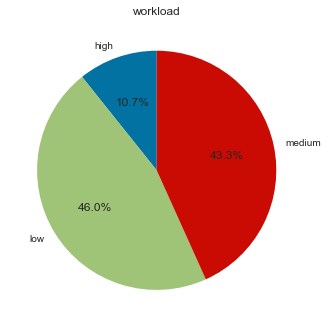

Соотношение максимальной группы к минимальной: 4.289256198347108


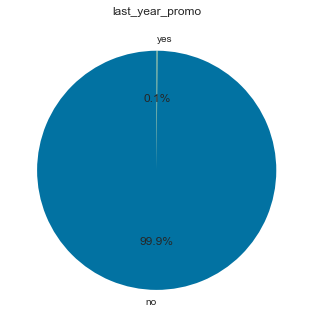

Соотношение максимальной группы к минимальной: 1127.0


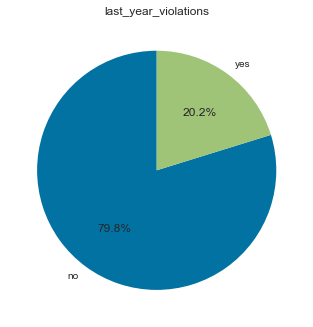

Соотношение максимальной группы к минимальной: 3.9473684210526314


In [57]:
for col in obj_cols:
    if col == 'quit':
        continue
    data_tmp = quit_data.pivot_table(index = col, values = 'id', aggfunc = 'count')
    plt.pie(data_tmp['id'], labels = data_tmp.index, autopct = '%1.1f%%', startangle = 90)
    plt.title(col)
    plt.show()
    print(f"Соотношение максимальной группы к минимальной: {data_tmp['id'].max() / data_tmp['id'].min()}")

Заметим, что больше всего уволенных сотрудников занимаются продажами, а меньше всего - hr. Больше всего обладают уровнем `junior`, я думаю это можно объяснить ростом уровня знаний и неповышением зарплаты сотруднику, иногда проще найти новую работу с подходящей зп, чем пытаться просить больше в компании, где уже работаешь. Загруженность чаще всего слабая у таких сотрудников, всего лишь 0.1% получили повышение, 20.2% нарушили трудовогой договор

In [58]:
for col in num_cols:
    if col == 'quit':
        continue
    print("\n")
    print(col)
    display(quit_data[col].describe())
    print("\n")
    print("\n")



employment_years


count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64







supervisor_evaluation


count    1128.000000
mean        3.046099
std         0.973291
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64







salary


count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

In [59]:
train_data_quit.query('quit == "no"')['salary'].describe()

count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64

В среднем уволенные сотрудники работают 4 года, максимум - 10, минимум - 1 год. \
Удивительно, но такие сотрудники имеют медиану оценки руководителя, равную 4, а значит в среднем эти сотрудники удовлетворяли руководство \
Медиана зарплаты оставшегося сотрудника - 34800, в то время как у уволенного - 22800, скорее всего это подкрепляет, почему работники уровня `junior` уходят чаще. \

### Вывод по исследовательскому анализу:
Смотря на диаграммы категориальных признаков, можно сказать, что выводы совпадают с выводами в ходе исследовательского анализа первой задачи, но нужно добавить про колонку `quit`, а именно, что процент уволенных сотрудников ~28%, что довольно много, как я считаю

Гистограмма стажа работы вполне примитивна, много сотрудников работают около двух лет, более опытных сотрудников меньше и меньше с увеличением значения стажа. \
Минимальный стаж сотрудников - 1 год, медиана - 3 года, максимальный - 10 лет
Гистограмма выставления оценок руководителем в принципе тоже ожидаема, множество сотрудников стараются, потому медиана составляет 4 из 5, но и присутсвуют недобросовестные сотрудники с оценкой равной 1.

График распределения зарплаты напоминает распределение Пуасонна, вполне ожидаемо, что хвост будет протягиваться в сторону высоких зарплат с медианой около начала координат. \
Минимальная зарплата - 12000, медиана - 30000, максимальная - 96000. Причем по ящику с усами видно, что наблюдаются выбросы выше 3 квантиля, что полне логично с таким распределением, людей многозарабатывающих не так много

## Корреляционный анализ

Заметим, что предсказанный признак `job_satisfaction_rate` может явно коррелировать с таргет признаком, потому необходимо добавить этот признак в train и test данные

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.581035
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.825941
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.319989
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.256942
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.730160
...,...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no,0.554199
3996,672059,sales,middle,high,9,no,no,4,52800,no,0.769047
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.463505
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no,0.507309


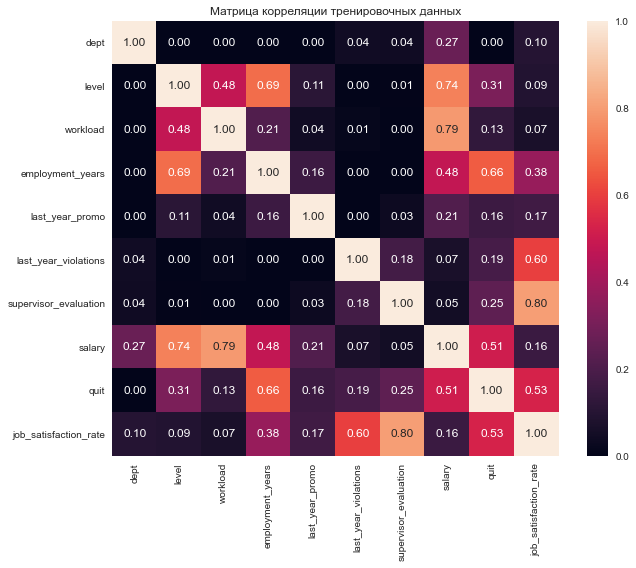

In [60]:
y_pred_df = pd.DataFrame(data = y_predict, columns=['job_satisfaction_rate'])
test_data_quit = test_data_features.merge(y_pred_df, left_index=True, right_index=True).merge(test_data_target_quit, on='id')
X_q_encoded = best_model_preprocessor.transform(train_data_quit)
train_data_quit['job_satisfaction_rate'] = best_model.predict(X_q_encoded)
display(train_data_quit)

interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

fig, axes = plt.subplots(figsize=(10, 8))
sns.heatmap(train_data_quit.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f', ax=axes)

plt.title('Матрица корреляции тренировочных данных')
plt.show()


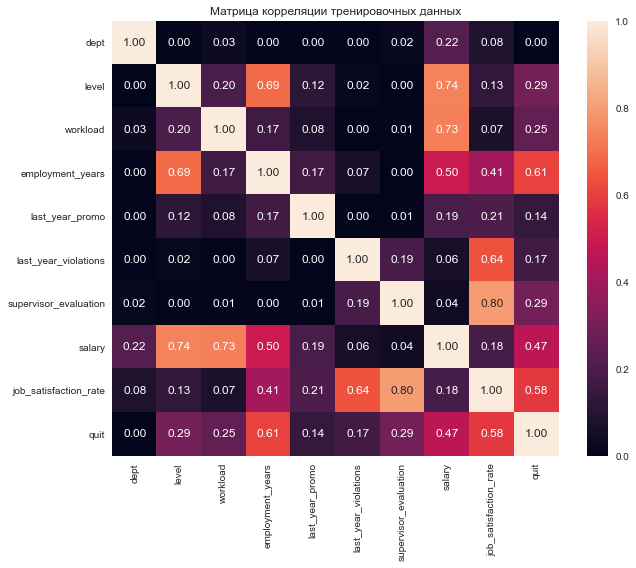

In [61]:
fig, axes = plt.subplots(figsize=(10, 8))
sns.heatmap(test_data_quit.drop(['id'], axis=1).phik_matrix(interval_cols = interval_cols), annot=True, fmt='.2f', ax=axes)

plt.title('Матрица корреляции тренировочных данных')
plt.show()


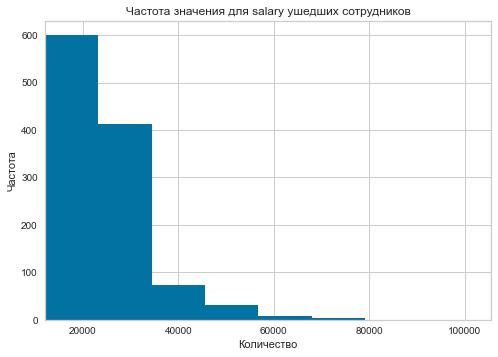

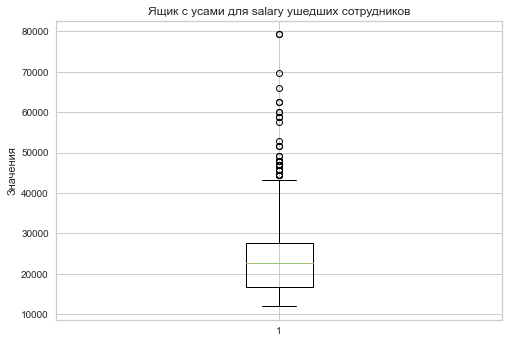



Статистика ушедших сотрудников


count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

In [62]:
train_data_quit.query('quit == "yes"')[col].hist(bins = math.ceil(np.log(len(train_data_quit[col].unique())) + 1))
plt.xlim(train_data_quit.query('quit == "yes"')[col].min(), train_data_quit[col].max() * 1.1)
plt.title(f"Частота значения для {col} ушедших сотрудников")
plt.ylabel('Частота')
plt.xlabel('Количество')
plt.show()
print("\n")
plt.boxplot(train_data_quit.query('quit == "yes"')[col])
plt.title(f"Ящик с усами для {col} ушедших сотрудников")
plt.ylabel('Значения')
plt.show()
print("\n")
print("Статистика ушедших сотрудников")
display(train_data_quit.query('quit == "yes"')[col].describe())
print("\n")
print("\n")

Посмотрим, как распределены оценки удовлетворенности ушедших и не ушедших сотрудников

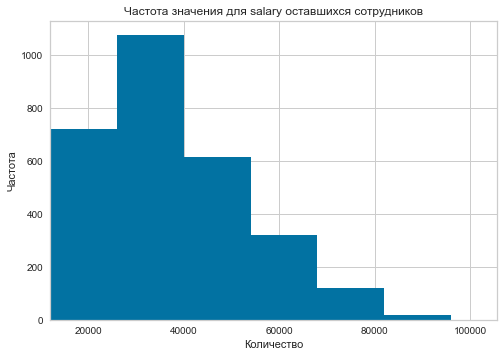

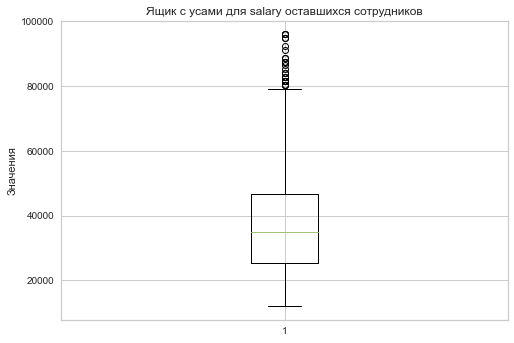



Статистика оставшихся сотрудников


count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64

In [63]:
train_data_quit.query('quit == "no"')[col].hist(bins = math.ceil(np.log(len(train_data_quit[col].unique())) + 1))
plt.xlim(train_data_quit.query('quit == "no"')[col].min(), train_data_quit[col].max() * 1.1)
plt.title(f"Частота значения для {col} оставшихся сотрудников")
plt.ylabel('Частота')
plt.xlabel('Количество')
plt.show()
print("\n")
plt.boxplot(train_data_quit.query('quit == "no"')[col])
plt.title(f"Ящик с усами для {col} оставшихся сотрудников")
plt.ylabel('Значения')
plt.show()
print("\n")
print("Статистика оставшихся сотрудников")
display(train_data_quit.query('quit == "no"')[col].describe())
print("\n")
print("\n")

Заметим, что медиана зарплаты среди уволенных сотрудников меньше медианы оставшихся, что вполне логично ввиду большого оттока джуниор специалистов

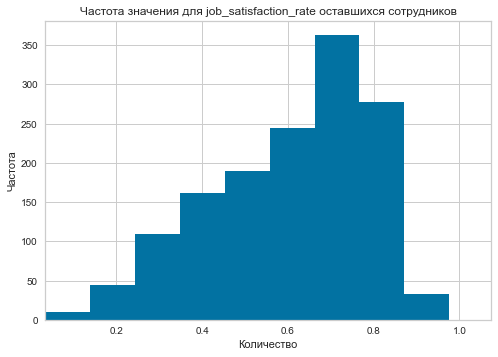

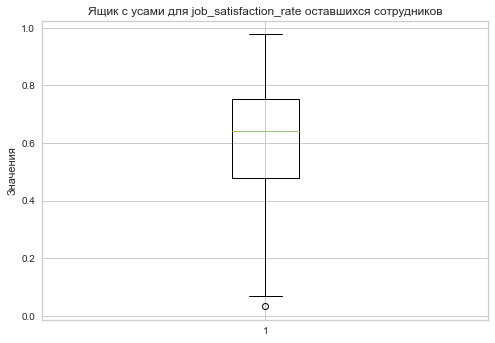



Статистика оставшихся сотрудников


count    1436.000000
mean        0.606964
std         0.185811
min         0.033329
25%         0.477786
50%         0.641062
75%         0.752027
max         0.976632
Name: job_satisfaction_rate, dtype: float64

In [64]:
test_data_quit.query('quit == "no"')['job_satisfaction_rate'].hist(bins = math.ceil(np.log(len(test_data_quit['job_satisfaction_rate'].unique())) + 1))
plt.xlim(test_data_quit.query('quit == "no"')['job_satisfaction_rate'].min(), test_data_quit['job_satisfaction_rate'].max() * 1.1)
plt.title(f"Частота значения для {'job_satisfaction_rate'} оставшихся сотрудников")
plt.ylabel('Частота')
plt.xlabel('Количество')
plt.show()
print("\n")
plt.boxplot(test_data_quit.query('quit == "no"')['job_satisfaction_rate'])
plt.title(f"Ящик с усами для {'job_satisfaction_rate'} оставшихся сотрудников")
plt.ylabel('Значения')
plt.show()
print("\n")
print("Статистика оставшихся сотрудников")
display(test_data_quit.query('quit == "no"')['job_satisfaction_rate'].describe())
print("\n")
print("\n")

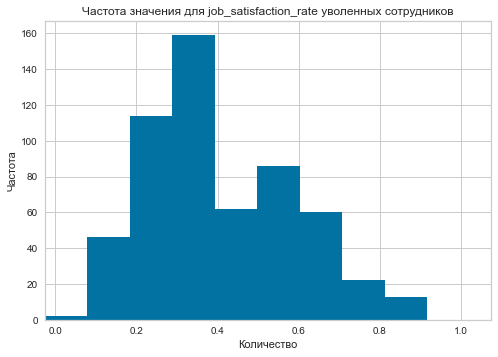

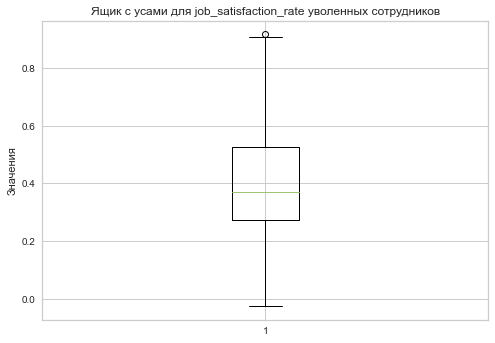



Статистика уволенных сотрудников


count    564.000000
mean       0.402973
std        0.178141
min       -0.025285
25%        0.272090
50%        0.370305
75%        0.527452
max        0.916026
Name: job_satisfaction_rate, dtype: float64

In [65]:
test_data_quit.query('quit == "yes"')['job_satisfaction_rate'].hist(bins = math.ceil(np.log(len(test_data_quit['job_satisfaction_rate'].unique())) + 1))
plt.xlim(test_data_quit.query('quit == "yes"')['job_satisfaction_rate'].min(), test_data_quit['job_satisfaction_rate'].max() * 1.1)
plt.title(f"Частота значения для {'job_satisfaction_rate'} уволенных сотрудников")
plt.ylabel('Частота')
plt.xlabel('Количество')
plt.show()
print("\n")
plt.boxplot(test_data_quit.query('quit == "yes"')['job_satisfaction_rate'])
plt.title(f"Ящик с усами для {'job_satisfaction_rate'} уволенных сотрудников")
plt.ylabel('Значения')
plt.show()
print("\n")
print("Статистика уволенных сотрудников")
display(test_data_quit.query('quit == "yes"')['job_satisfaction_rate'].describe())
print("\n")
print("\n")

Заметим, что среди уволенных сотрудников обнаружены отрицательные значения, это аномалия после прогнозирования, посмотрим, сколько таких данных

In [66]:
test_data_quit.query('quit == "yes"')[test_data_quit.query('quit == "yes"')['job_satisfaction_rate'] - 1e-8 < 0.0]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
67,389687,sales,sinior,high,2,no,yes,2,63600,-0.025285,yes


Всего одно наблюдение, я бы взял это значение по модулю

In [67]:
test_data_quit['job_satisfaction_rate'] = np.abs(test_data_quit['job_satisfaction_rate'])

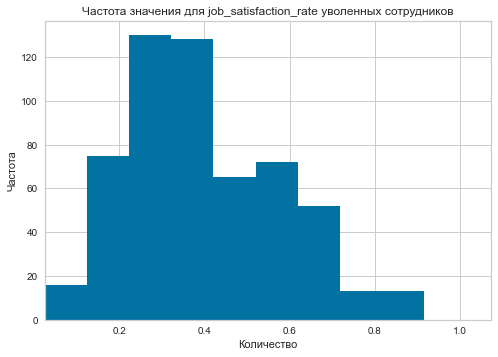

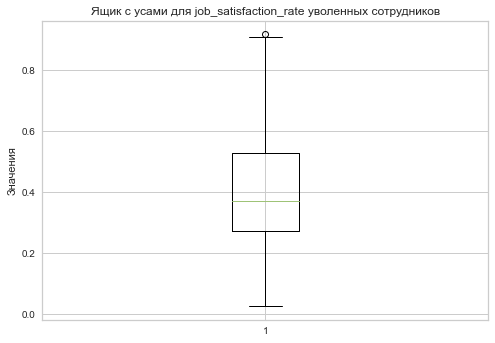



Статистика уволенных сотрудников


count    564.000000
mean       0.403062
std        0.177937
min        0.025285
25%        0.272090
50%        0.370305
75%        0.527452
max        0.916026
Name: job_satisfaction_rate, dtype: float64

In [68]:
test_data_quit.query('quit == "yes"')['job_satisfaction_rate'].hist(bins = math.ceil(np.log(len(test_data_quit['job_satisfaction_rate'].unique())) + 1))
plt.xlim(test_data_quit.query('quit == "yes"')['job_satisfaction_rate'].min(), test_data_quit['job_satisfaction_rate'].max() * 1.1)
plt.title(f"Частота значения для {'job_satisfaction_rate'} уволенных сотрудников")
plt.ylabel('Частота')
plt.xlabel('Количество')
plt.show()
print("\n")
plt.boxplot(test_data_quit.query('quit == "yes"')['job_satisfaction_rate'])
plt.title(f"Ящик с усами для {'job_satisfaction_rate'} уволенных сотрудников")
plt.ylabel('Значения')
plt.show()
print("\n")
print("Статистика уволенных сотрудников")
display(test_data_quit.query('quit == "yes"')['job_satisfaction_rate'].describe())
print("\n")
print("\n")

По графику распределений видно, что медиана уволенных сотрудников меньше медианы оставшихся, что вполне логично. Уволенный сотрудник скорее всего неудовлетворен работой, иначе вряд ли он захочет уволиться

## Вывод по корреляционному анализу:
На показатель ухода больше всего влияет по коэффициенту корреляции - `salary`, `supervisor_evaluation`, `employment_years`, `level`, `job_satisfaction_rate` что вполне логично, зарплата, оценка руководителя, время работы, уровень знаний, удовлетворенность - действительно важные факторы в жизни сотрудника, а особенно, когда речь идет об увольнении

## Подготовка данных

Напишем пайплайны, а таргет закодируем при помощи LabelEncoder

In [69]:
ohe_cols = ['dept', 'workload', 'last_year_promo', 'last_year_violations']
ord_cols = ['level']
num_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


In [70]:
pipe_final_class = Pipeline(
    [
        ('preprocessor', data_preprocessing),
        ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
    ]
)

## Обучение моделей

Будем перебирать несколько моделей с разными гиперпараметрами

In [71]:
param_grid_class = [
    {
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [SVC(random_state = RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state = RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

Закодируем таргет признаки LabelEncoder`ом 

In [72]:
l_encoder = LabelEncoder()
y_tr_encoded = l_encoder.fit_transform(train_data_quit['quit'])
y_te_encoded = l_encoder.transform(test_data_quit['quit'])
y_te_encoded

array([0, 0, 0, ..., 1, 0, 0])

In [73]:
randomized_search_classifier = RandomizedSearchCV(
    pipe_final_class,
    param_grid_class,
    cv = 5,
    scoring = 'roc_auc',
    random_state = RANDOM_STATE,
    n_jobs = -1
)
randomized_search_classifier.fit(train_data_quit.drop(['id', 'quit'], axis = 1), y_tr_encoded)
print('Лучшая модель и её параметры:\n\n', randomized_search_classifier.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_classifier.best_score_)
y_test_pred_proba = randomized_search_classifier.predict_proba(test_data_quit.drop(['id', 'quit'], axis = 1))
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_te_encoded, y_test_pred_proba[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[

Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros


## Оформление выводов

По итогу работы пайплайна лучшей моделью оказалась `DecisionTreeClassifier` с `max_depth = 5`. Метрика на тестовых данных = ~0.93, что очень хорошо и удовлетворяет нашим требованиям

## Общий вывод

В ходе выполнения проекта мне удалось обучить две модели для задачи регресии и квалификации, а именно, подбирая необходимые гиперпараметры в пайплайне, я получил модель `SVR`, `DecisionTreeClassifier` соответственно. Задача регрессии - предсказать уровень удовлетворенности сотрудника, задача классификации - предсказать отток сотрудника из компании. \
За все время решения этих двух задач можно выделить некоторые под-выводы, а именно:

## Вывод по предобработке данных задачи 1:
Заметим, что пропусков совсем немного, 6 строк по максимуму из 4000, думаю эти данные можно вовсе отбросить, но в будущем воспользуемся пайплайном, где стратегией заполнения будет `most-frequent`

### Вывод по исследовательскому анализу задачи 1:
По данным категориальных диаграмм можно сделать несколько выводов:
- Большая часть работников занимаются продажами, в то время как меньшая часть - hr, примерно поровну - маркетинг и закупки, почти второе место занимает отдел технологий
- Больше всего работников уровня джуниор и чуть меньше мидлов и совсем мало сеньоров, вполне ожидаемые показатели для почти любой компании
- По загруженности видно, что примерно половина занята средне, в то время как низкая загруженность у 30 процентов сотрудников, у 18 процентов - высокая
- Видно что повышение получили всего 3 процента сотрудников в течение года
- По диаграмме нарушений видно, что всего 14 процентов сотрудников нарушили трудовой договор, в целом хорошая цифра, но было бы хорошо иметь этот показатель еще более низким

Гистограмма стажа работы вполне примитивна, много сотрудников работают около двух лет, более опытных сотрудников меньше и меньше с увеличением значения стажа. \
Минимальный стаж сотрудников - 1 год, медиана - 3 года, максимальный - 10 лет
Гистограмма выставления оценок руководителем в принципе тоже ожидаема, множество сотрудников стараются, потому медиана составляет 4 из 5, но и присутсвуют недобросовестные сотрудники с оценкой равной 1.
Причем это явно выброс, Содержится 201 строчка с такой оценкой, причем уровни должности из всего спектра, сеньоры так же получают низкие оценки. Данные не являются аномалдьными, например есть hr со стажем в 10 лет, может он уже просто не компетентный, потому и получил такую оценку.

График распределения зарплаты напоминает распределение Пуасонна, вполне ожидаемо, что хвост будет протягиваться в сторону высоких зарплат с медианой около начала координат. \
Минимальная зарплата - 12000, медиана - 30000, максимальная - 98400. Причем по ящику с усами видно, что наблюдаются выбросы выше 3 квантиля, что полне логично с таким распределением, людей многозарабатывающих не так много

Гистограмма оценки удовлетворенности сотрудника напоминает нормальное распределение, но с небольшим смещеним в бОльшую сторону, что весьма хорошо, это означает, что медиана находится выше чем половина оценки. Видно, что медиана составляет 0.56, в то время как наблюдаются очень подозрительные значения, 0.03 - минимальное, видно, что все эти пользователи нарушили трудовой договор, потому ожидаемо, чем вызвана такая неудовлетворенность

В ходе выполнения первого задания удалось обучить модель `SVR`, показавшую примерно результат ~13.8 по метрике smape, что удовлетворяет нашим требованиям

### Вывод по предобработке данных задачи 2:
Пропуски, дубликаты в данных не обнаружены, оставим все как есть

### Вывод по исследовательскому анализу задачи 2:
Смотря на диаграммы категориальных признаков, можно сказать, что выводы совпадают с выводами в ходе исследовательского анализа первой задачи, но нужно добавить про колонку `quit`, а именно, что процент уволенных сотрудников ~28%, что довольно много, как я считаю

Гистограмма стажа работы вполне примитивна, много сотрудников работают около двух лет, более опытных сотрудников меньше и меньше с увеличением значения стажа. \
Минимальный стаж сотрудников - 1 год, медиана - 3 года, максимальный - 10 лет
Гистограмма выставления оценок руководителем в принципе тоже ожидаема, множество сотрудников стараются, потому медиана составляет 4 из 5, но и присутсвуют недобросовестные сотрудники с оценкой равной 1.

График распределения зарплаты напоминает распределение Пуасонна, вполне ожидаемо, что хвост будет протягиваться в сторону высоких зарплат с медианой около начала координат. \
Минимальная зарплата - 12000, медиана - 30000, максимальная - 96000. Причем по ящику с усами видно, что наблюдаются выбросы выше 3 квантиля, что полне логично с таким распределением, людей многозарабатывающих не так много

### Портрет «уволившегося сотрудника»:
Заметим, что больше всего уволенных сотрудников занимаются продажами, а меньше всего - hr. Больше всего обладают уровнем `junior`, я думаю это можно объяснить ростом уровня знаний и неповышением зарплаты сотруднику, иногда проще найти новую работу с подходящей зп, чем пытаться просить больше в компании, где уже работаешь. Загруженность чаще всего слабая у таких сотрудников, всего лишь 0.1% получили повышение, 20.2% нарушили трудовогой договор

В среднем уволенные сотрудники работают 4 года, максимум - 10, минимум - 1 год. \
Удивительно, но такие сотрудники имеют медиану оценки руководителя, равную 4, а значит в среднем эти сотрудники удовлетворяли руководство \
Медиана зарплаты оставшегося сотрудника - 34800, в то время как у уволенного - 22800, скорее всего это подкрепляет, почему работники уровня `junior` уходят чаще. \


## Вывод по корреляционному анализу задачи 2:
На показатель ухода больше всего влияет по коэффициенту корреляции - `salary`, `supervisor_evaluation`, `employment_years`, `level`, `job_satisfaction_rate` что вполне логично, зарплата, оценка руководителя, время работы, уровень знаний, удовлетворенность - действительно важные факторы в жизни сотрудника, а особенно, когда речь идет об увольнении

По итогу работы пайплайна лучшей моделью оказалась `DecisionTreeClassifier` с `max_depth = 5`. Метрика на тестовых данных = ~0.93, что очень хорошо и удовлетворяет нашим требованиям